In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from PIL import Image
import os
import matplotlib.pyplot as plt
import time

In [ ]:
ps = 64   # patch size (Height and Width)
enc_chs = 5 * 4*2    # compression_ratio = 5 * 1/12
stages_count = 5
dec_chs = enc_chs // stages_count
SNR = 13

epochs = 500
batch_size = int(32 * (32/ps)**2)
loss_func = torch.nn.MSELoss()  # PyTorch Mean Squared Error Loss

train_count = int(50000 * (32/ps)**2)   # number of patches in trainset
test_count = int(10000 * (32/ps)**2)   # number of patches in testset

In [ ]:
class PowerNormParts(nn.Module):
    def __init__(self, parts_count, cplx=False, part_last_dim=True, **kwargs):
        super().__init__(**kwargs)
        self.pc = parts_count
        self.cplx = cplx
        self.part_last_dim = part_last_dim

    def forward(self, inputs):
        shape = inputs.shape
        if self.part_last_dim:
            inputs = inputs.view(shape[0], -1, shape[-1]).permute(0, 2, 1)

        flatp = inputs.reshape(shape[0], self.pc, -1)
        if self.cplx:
            dsize = flatp.shape[2] // 2
        else:
            dsize = flatp.shape[2]
        dsize_f = torch.tensor(dsize).float()

        norm = torch.norm(flatp, dim=2)
        norm = norm.unsqueeze(dim=-1)

        out = torch.sqrt(dsize_f) * flatp / norm
        if self.part_last_dim:
            out = out.view(shape[0], shape[-1], -1).permute(0, 2, 1)
        out = out.view(shape)
        return out

In [ ]:
class Channel(nn.Module):
    def __init__(self, snr, cplx=False, **kwargs):
        super().__init__(**kwargs)
        self.cplx = cplx
        self.snr = snr
        self.set_noise_std()

    def forward(self, inputs):
        shape = inputs.shape
        # Generate noise with standard normal distribution
        gnoise = torch.randn(shape)
        # Scale and shift the noise to have the desired standard deviation and mean
        gnoise = gnoise * self.noise_std
        return inputs + gnoise

    def get_snr(self):
        return self.snr

    def set_snr(self, snr):
        self.snr = snr
        self.set_noise_std()

    def set_noise_std(self):
        if self.cplx:
            self.noise_std = np.sqrt(10**(-self.snr/10)) / np.sqrt(2)
        else:
            self.noise_std = np.sqrt(10**(-self.snr/10))


In [ ]:
def calculate_psnr(output, target, max_val=1.0):
    mse = nn.functional.mse_loss(output, target)
    psnr = 10 * torch.log10(max_val ** 2 / mse)
    return psnr

In [ ]:
def PSNR_plotter(x_axis, model, channel, test_loader, stages_count=1, goal=None):
    sc = stages_count
    PSNRs = np.zeros((sc, len(x_axis)))
    pre_snr = channel.get_snr()

    model.eval()
    with torch.no_grad():
        for i, snr in enumerate(x_axis):
            channel.set_snr(snr)
            batch_psnrs = [[] for _ in range(sc)]

            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                preds = model(data)

                for j in range(sc):
                    psnr = calculate_psnr(preds[j], target)
                    batch_psnrs[j].append(psnr.item())

            # Average the PSNR values over the test set for each stage
            for j in range(sc):
                PSNRs[j, i] = np.mean(batch_psnrs[j])

    channel.set_snr(pre_snr)

    # Plotting
    for i in range(sc):
        plt.plot(x_axis, PSNRs[i], label='Stage_' + str(i+1))
    if goal is not None:
        plt.plot(x_axis, goal, label='Goal')

    plt.xlabel('SNR')
    plt.ylabel('PSNR')
    plt.title('PSNR vs SNR for Different Stages')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [ ]:
class PSNR_metric(nn.Module):
    def __init__(self, name="PSNR"):
        super(PSNR_metric, self).__init__()
        self.name = name
        self.PSNR_additive = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.counter = nn.Parameter(torch.tensor(0.0), requires_grad=False)

    def update_state(self, y_true, y_pred, sample_weight=None):
        mse = torch.mean((y_true - y_pred) ** 2)
        psnr = 10 * torch.log10(1.0 / mse)
        self.PSNR_additive += psnr
        self.counter += 1

    def result(self):
        return self.PSNR_additive / self.counter

    def reset_states(self):
        self.PSNR_additive = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.counter = nn.Parameter(torch.tensor(0.0), requires_grad=False)

In [ ]:
def lr_scheduler(epoch):
  if epoch == 0:
    print("\nlearning_rate: 0.001")
  elif epoch == 20:
    print("\nlearning_rate: 0.0005")
  elif epoch == 30:
    print("\nlearning_rate: 0.0001")

  if epoch < 20:
    return 0.001
  elif epoch < 30:
    return 0.0005
  else:
    return 0.0001

In [ ]:
class FuncCaller:
    def __init__(self, period, function, *args, **kwargs):
        self.period = period
        self.fn = function
        self.args = args
        self.kwargs = kwargs

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.period == 0:
            self.fn(*self.args, **self.kwargs)


In [ ]:
class EpochDotter:
    def __init__(self, nl_period, dot_period=1):
        self.nl_period = nl_period
        self.dot_period = dot_period
        self.tic = time.time()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.dot_period == 0:
            print('.', end='')

        if epoch % self.nl_period == 0:
            toc = time.time()
            print(" {} epochs".format(epoch), end='')
            if self.tic is not None:
                print(" - {0:.2f}s/epoch".format((toc - self.tic)/self.nl_period), end='')
            if logs is not None:
                for key, value in logs.items():
                    if "val" in key:
                        print(" - {}: {:.4f}".format(key, value), end='')
            print("")
            self.tic = time.time()

In [ ]:
pip install git+https://github.com/modestyachts/ImageNetV2_pytorch

  Cloning https://github.com/modestyachts/ImageNetV2_pytorch to /tmp/pip-req-build-hat9r679
  Running command git clone --filter=blob:none --quiet https://github.com/modestyachts/ImageNetV2_pytorch /tmp/pip-req-build-hat9r679
  Resolved https://github.com/modestyachts/ImageNetV2_pytorch to commit 14d4456c39fe7f02a665544dd9fc37c1a5f8b635
  Preparing metadata (setup.py) ... done


In [ ]:
from imagenetv2_pytorch import ImageNetV2Dataset

# Load the ImageNetV2 dataset
dataset = ImageNetV2Dataset("matched-frequency")

# Extract the first N images
N = 10000  # Number of images you want to use
pil_images = [dataset[i][0] for i in range(N)]  # dataset[i][0] gives the PIL image

In [ ]:
class ImagePatchesDataset(Dataset):
    def __init__(self, images, patch_size, train_count, test_count):
        self.images = images
        self.patch_size = patch_size
        self.train_count = train_count
        self.test_count = test_count
        self.patches = self._preprocess()

    def _preprocess(self):
        patches = []
        l = 0
        for img in self.images:
            # Assuming img is a PIL Image, convert to NumPy array
            img_np = np.array(img)
            shape = img_np.shape
            tile_dim0 = shape[0] // self.patch_size
            tile_dim1 = shape[1] // self.patch_size
            img_np = img_np[:tile_dim0 * self.patch_size, :tile_dim1 * self.patch_size]
            img_np = img_np.reshape(tile_dim0, self.patch_size, tile_dim1, self.patch_size, shape[-1])
            img_np = img_np.transpose(0, 2, 1, 3, 4)
            img_np = img_np.reshape(tile_dim0 * tile_dim1, self.patch_size, self.patch_size, shape[-1])
            patches.append(img_np)
            l += len(img_np)
            if l > (self.train_count + self.test_count):
                break
        return np.vstack(patches)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch = self.patches[idx]
        patch = torch.tensor(patch).float() / 255.0
        patch = patch.permute(2, 0, 1)  # Change to (C, H, W) format
        return patch, patch  # Returning the same patch as input and target

In [ ]:
patch_size = 64
train_count = 8000
test_count = 2000

patches_dataset = ImagePatchesDataset(pil_images, patch_size, train_count, test_count)

In [ ]:
def create_encoder(out_chs, img_shape=(3, None, None), name=None):
    encoder_layers = [
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2, padding=2),
        nn.PReLU(num_parameters=16),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=2),
        nn.PReLU(num_parameters=32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.PReLU(num_parameters=32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.PReLU(num_parameters=32),
        nn.Conv2d(in_channels=32, out_channels=out_chs, kernel_size=5, stride=1, padding=2)
    ]
    encoder = nn.Sequential(*encoder_layers)
    if name:
        encoder.name = name  # PyTorch modules don't have a 'name' attribute by default
    return encoder

In [ ]:
def create_decoder(in_channels, img_chs=3, name=None):
    decoder_layers = [
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.PReLU(num_parameters=32),
        nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.PReLU(num_parameters=32),
        nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.PReLU(num_parameters=32),
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, stride=2, padding=2, output_padding=1),
        nn.PReLU(num_parameters=16),
        nn.ConvTranspose2d(in_channels=16, out_channels=img_chs, kernel_size=5, stride=2, padding=2, output_padding=1),
        nn.Sigmoid()
    ]
    decoder = nn.Sequential(*decoder_layers)
    if name:
        decoder.name = name  # PyTorch modules don't have a 'name' attribute by default
    return decoder

In [ ]:
class DeepJSCC(nn.Module):
    def __init__(self, enc_chs, stages_count, SNR):
        super(DeepJSCC, self).__init__()
        self.encoder = create_encoder(enc_chs)
        self.powernorm = PowerNormParts(stages_count, cplx=True)
        self.channel = Channel(SNR, cplx=True)
        self.decoders = nn.ModuleList([create_decoder(dec_chs * (i + 1)) for i in range(stages_count)])
        self.loss_func = nn.MSELoss()

    def forward(self, x):
        encoder_out = self.encoder(x)
        power_out = self.powernorm(encoder_out)
        channel_out = self.channel(power_out)

        outputs = []
        for i, decoder in enumerate(self.decoders):
            decoder_input = channel_out[:, :dec_chs*(i+1), :, :]
            decoder_output = decoder(decoder_input)
            outputs.append(decoder_output)

        return outputs

    def calculate_loss(self, target, outputs):
      losses = []
      for output in outputs:
          # Ensure output and target have the same shape
          if output.shape == target.shape:
              loss = self.loss_func(output, target)
              losses.append(loss)
          else:
              print(f"Output shape {output.shape} does not match target shape {target.shape}")
      return sum(losses)

In [ ]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Your model
model = DeepJSCC(enc_chs, stages_count, SNR).to(device)

initial_lr = 0.001
opt = torch.optim.Adam(model.parameters(), lr=initial_lr)

Using device: cpu


In [ ]:
known_SNRs  = [1, 4, 7, 13, 19]
test_SNRs   = [1, 4, 7, 10, 13, 16, 19, 22, 25]
known_goals = [[24.636, 25.964, 26.618, 26.945, 27.109, 27.182, 27.236, 27.255, 27.273],
              [23.836, 26.655, 28.091, 28.909, 29.309, 29.527, 29.636, 29.673, 29.709],
              [21.836, 25.945, 28.545, 30.091, 31.055, 31.618, 31.945, 32.091, 32.182],
              [21.036, 23.836, 26.455, 28.854, 30.836, 32.345, 33.382, 34.036, 34.382],
              [20.291, 23.127, 25.891, 28.473, 30.745, 32.655, 34.073, 35.036, 35.600]]

idx = np.where(np.array(known_SNRs) == SNR)[0]
if idx.size == 0:
  goal = None
else:
  idx = idx[0]
  goal = known_goals[idx]

goal = None   # we don't want to use the result of main paper here


learning_rate: 0.001
. 0 epochs - 20.97s/epoch - val_loss: 0.4097 - val_psnr: 10.9122


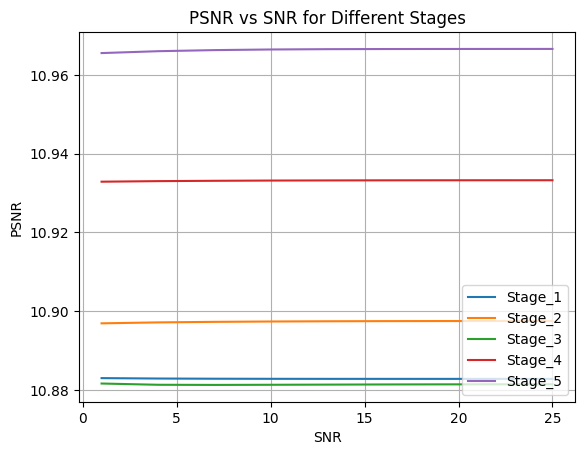

KeyboardInterrupt: ignored

In [ ]:
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_scheduler)

# Split the dataset into train and test
train_size = int(0.7 * len(patches_dataset))
test_size = len(patches_dataset) - train_size
train_dataset, test_dataset = random_split(patches_dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

psnr_metrics = [PSNR_metric() for _ in range(len(model.decoders))]  # One PSNR_metric instance for each decoder

# Initialize the EpochDotter
epoch_dotter = EpochDotter(nl_period=10, dot_period=1)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        opt.zero_grad()  # Zero the gradients

        outputs = model(data)  # Forward pass, outputs is a list of tensors

        # Calculate loss using the custom method
        loss = model.calculate_loss(target, outputs)

        loss.backward()  # Backward pass
        opt.step()  # Update weights

        total_loss += loss.item()

    scheduler.step()  # Update learning rate

    # Validation step
    model.eval()
    with torch.no_grad():
        validation_psnrs = []
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)

            for i, output in enumerate(outputs):
                psnr_metrics[i].update_state(target, output)

        # Print PSNRs and reset states
        for i, metric in enumerate(psnr_metrics):
            avg_psnr = metric.result().item()
            validation_psnrs.append(avg_psnr)
            metric.reset_states()

    # Print epoch information using EpochDotter
    logs = {'val_loss': total_loss / len(train_loader), 'val_psnr': np.mean(validation_psnrs)}
    epoch_dotter.on_epoch_end(epoch, logs)

    if epoch % 10 == 0:
        PSNR_plotter(test_SNRs, model, model.channel, test_loader, len(model.decoders), goal)

# Save the entire model
torch.save(model, 'entire_model.pth')


In [ ]:
# Convert testX to a PyTorch tensor
testX_tensor = torch.tensor(test_dataset, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

# Randomly select a subset of images from the test set
idxs = np.random.randint(0, len(testX_tensor), 10)
imgs = testX_tensor[idxs]

# Generate predictions
with torch.no_grad():  # No gradients needed for evaluation
    preds = model(imgs)

# Plot the original images and predictions
fig = plt.figure(figsize=(2.5 * (stages_count + 1), 2.5 * len(imgs)))
for i in range(len(imgs)):
    for j in range(stages_count):
        # Convert the prediction back to a numpy array for plotting
        pred = preds[j][i].cpu().numpy()
        fig.add_subplot(len(imgs), stages_count + 1, i * (stages_count + 1) + j + 1)
        plt.imshow(pred)
        plt.axis('off')  # Hide the axis

    # Plot the original image
    fig.add_subplot(len(imgs), stages_count + 1, (i + 1) * (stages_count + 1))
    plt.imshow(imgs[i].cpu().numpy())
    plt.axis('off')  # Hide the axis

plt.show()